In [ ]:
import pandas as pd
import numpy as np
import ast
from pathlib import Path

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [ ]:
#github link: https://github.com/teagankryan/DS_Project

In [ ]:
df = pd.read_csv('/content/imdb_clean.csv')

#**PRE MODEL IMPLEMENTATION CLEANING**

In [ ]:
# Replace \N with NaN
df = df.replace("\\N", np.nan)
# Drop unnecessary columns
df = df.drop(columns=["originalTitle", "isAdult", "endYear"], errors="ignore")

In [ ]:
df

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
0,tt0000009,movie,Miss Jerry,1894,45,['Romance'],5.4,228,nm0085156,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,100,"['Documentary', 'News', 'Sport']",5.2,570,nm0714557,NaN
2,tt0000502,movie,Bohemios,1905,100,[],3.6,22,nm0063413,"nm0063413,nm0657268,nm0675388"
3,tt0000574,movie,The Story of the Kelly Gang,1906,70,"['Action', 'Adventure', 'Biography']",6.0,1023,nm0846879,nm0846879
4,tt0000591,movie,The Prodigal Son,1907,90,['Drama'],5.3,34,nm0141150,nm0141150
...,...,...,...,...,...,...,...,...,...,...
302319,tt9916190,movie,Safeguard,2020,95,"['Action', 'Adventure', 'Thriller']",3.6,265,nm7308376,nm7308376
302320,tt9916270,movie,Il talento del calabrone,2020,84,['Thriller'],5.8,1519,nm1480867,"nm1480867,nm10538402,nm5584269"
302321,tt9916362,movie,Coven,2020,92,"['Drama', 'History']",6.4,6124,nm1893148,"nm1893148,nm3471432"
302322,tt9916538,movie,Kuambil Lagi Hatiku,2019,123,['Drama'],7.6,12,nm4457074,"nm4843252,nm4900525,nm2679404"


In [ ]:
# Coerce to numeric
df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce")
df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce")
df["averageRating"] = pd.to_numeric(df["averageRating"], errors="coerce")
df["numVotes"] = pd.to_numeric(df["numVotes"], errors="coerce")

# Filter for start year and movie
df = df[(df["startYear"] >= 2000) & (df["titleType"] == "movie") & (df['numVotes'] >= 500)].copy()

# Removes rows with NaN data
df = df.dropna(subset=["averageRating", "startYear"])

In [ ]:
# Converts string format into lists for movies with multiple genres
def parse_genres(s):
    if pd.isna(s) or s == "" or s == "[]":
        return []
    try:
        out = ast.literal_eval(s)
        if isinstance(out, list):
            return [g for g in out if isinstance(g, str) and g.strip() != ""]
        return []
    except Exception:
        return [str(s)] if isinstance(s, str) else []

# Converts string format into lists for movies with multiple writers/directors
def split_people(s):
    if pd.isna(s) or s == "":
        return []
    return [tok.strip() for tok in str(s).split(",") if tok.strip() != ""]

df["genres_parsed"] = df["genres"].apply(parse_genres)
df["directors_list"] = df["directors"].apply(split_people)
df["writers_list"] = df["writers"].apply(split_people)

In [ ]:
# Sort chronologically
df = df.sort_values(["startYear", "tconst"]).reset_index(drop=True)

In [ ]:
# Count the number of movies each writer has done previously for each movie

def writer_count(df, people_col = "writers_list", year_col = "startYear"):
  tmp = df[[year_col, people_col]].explode(people_col)
  tmp = tmp[tmp[people_col].notna() & (tmp[people_col] != "")]
  tmp = tmp.sort_values([people_col, year_col])

# Counts num movies
  counts = tmp.groupby([people_col, year_col]).size().rename("count").reset_index()

# Count of movies prior to year
  counts["prior_count"] = (counts.groupby(people_col)["count"].cumsum().shift(1).fillna(0))

  count_map = {
      (pid, yr): pc
      for pid, yr, pc in counts[[people_col, year_col, "prior_count"]].itertuples(index=False)
  }

  vals = []
  for _, row in df.iterrows():
    writers = row[people_col]
    yr = row[year_col]
    if not writers:
      vals.append(0)
      continue
    prior_counts = [count_map.get((w, yr), 0) for w in writers]
    vals.append(float(np.sum(prior_counts)))
  return pd.Series(vals)

df["prior_writer_count"] = writer_count(df)

In [ ]:
# Getting the average for each movie of all the previous movies made by its directos

def director_count(df, people_col = "directors_list", year_col = "startYear", target_col = "averageRating"):
  # Explode to one row per director and movie
  tmp = df[[year_col, people_col, target_col]].explode(people_col)
  tmp = tmp[tmp[people_col].notna() & (tmp[people_col] != "")]
  tmp = tmp.sort_values([people_col, year_col])

# For each director and year get average rating
  per_year = (
      tmp.groupby([people_col, year_col])[target_col]
      .mean().reset_index()
  )

  per_year["prior_mean"] = (
      per_year.groupby(people_col)[target_col]
      .expanding().mean().shift(1).values
  )

  # For each director compute mean and shift by 1
  per_year["prior_mean"] = (
      per_year.groupby(people_col)[target_col]
      .expanding().mean().shift(1).values
  )

  # Map director, year to prior_mean
  prior_map = {
      (pid,yr):pm
      for pid, yr, pm in per_year[[people_col, year_col, "prior_mean"]].itertuples(index=False)
  }

  # For each movie average means across all director
  prior_vals = []
  for _, row in df.iterrows():
    directors = row[people_col]
    yr = row[year_col]
    if not directors:
      prior_vals.append(0)
      continue
    vals = [prior_map.get((d,yr), np.nan) for d in directors]
    vals = [v for v in vals if pd.notna(v)]
    prior_vals.append(np.mean(vals) if len(vals) > 0 else np.nan)

  return pd.Series(prior_vals, index=df.index)

df["prior_director_mean"] = round(director_count(df), 2)


#**MODEL IMPLEMENTATION-TRAINING DETAILS**

The training process will begin with splitting the dataset
into training and testing subsets, using an 80/20 split. To
simulate real-world conditions, the split will be performed
chronologically, with the training set composed of the earliest 80% of titles and the testing set consisting of the remaining most recent 20%. This approach prevents information
leakage from future data and more accurately reflects a real
prediction scenario, such as ensuring that a sequel does not
appear in the training set when its predecessor is included
in the testing set. With that being said, the year of inflection we chose to divide our training and testing set was 2020.

In [ ]:
# Training tesing split

train_mask = (df["startYear"] < 2020)
test_mask  = (df["startYear"] >= 2020)

df["log1p_numVotes"] = np.log1p(df["numVotes"])

# One-hot genres as separate columns
all_genres = sorted({g for lst in df["genres_parsed"] for g in lst})
for g in all_genres:
    df[f"genre__{g}"] = df["genres_parsed"].apply(lambda L, g=g: 1 if g in L else 0)

num_features = [
    "startYear",
    "runtimeMinutes",
    "log1p_numVotes",
    "prior_director_mean",
    "prior_writer_count"
]

genre_cols = [c for c in df.columns if c.startswith("genre__")]

X = df[num_features + genre_cols].copy()
y = df["averageRating"].copy()

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

# Baseline Model

In [ ]:
# Baseline based off the mean of the target vector (will be used as comparison to Random Forest and Ridge Regression models)
baseline_pred = np.repeat(y_train.mean(), len(y_test))
baseline_rmse = mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Model Performance (Mean Rating)")
print(f"RMSE: {baseline_rmse:.3f}, MAE: {baseline_mae:.3f}, R²: {baseline_r2:.3f}")

Baseline Model Performance (Mean Rating)
RMSE: 1.709, MAE: 1.033, R²: -0.001


# Ridge Regression
Using 5-fold cross-validation, we aim to use training data to
identify the predictors that provide the best performance
while reducing the risk of overfitting. For ridge regression,
this process will involve selecting the optimal alpha level
to control the model penalization.

In [ ]:
# TimeSeries cross-validation
from sklearn.impute import SimpleImputer
set
#Ridge Regression Pipeline
time_cv = TimeSeriesSplit(n_splits=5)
ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])
# Grid of alpha values to search over
ridge_param_grid = {
    "model__alpha": np.logspace(-3, 3, 7)
}

ridge_cv = GridSearchCV(
    estimator = ridge_pipe,
    param_grid = ridge_param_grid,
    cv=time_cv,
    scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)

#Printing the Best Parameters
print("Best Ridge Parameters:", ridge_cv.best_params_)
print("Best Ridge Score:", -ridge_cv.best_score_)

# Try on test set
ridge_preds = ridge_cv.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_preds)
ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"Ridge Test RMSE: {ridge_rmse:.3f}, MAE: {ridge_mae:.3f}, R²: {ridge_r2:.3f}")

Best Ridge Parameters: {'model__alpha': np.float64(100.0)}
Best Ridge Score: 0.9385263619140553
Ridge Test RMSE: 1.183, MAE: 0.816, R²: 0.307


# Random Forest
Using 5 fold cross validation again, we will discover the model characteristics that yield the best performance metrics. For the random forest
model, adjustments will focus on key parameters such as
the number of trees, the depth of the trees, and how many
features are included at each split.

In [ ]:
# Random forest Pipeline
rf_pipe = Pipeline([
    ("model", RandomForestRegressor(random_state=10, n_jobs=-1))
])
# Hyperparameter grid for tuning
rf_param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 40, 60, 80],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_leaf": [1, 2, 4]
}
# Grid search (same TimeSeriesSplit as before)
rf_cv = GridSearchCV(rf_pipe, rf_param_grid, cv=time_cv, scoring="neg_mean_squared_error")
# Fit RF model
rf_cv.fit(X_train, y_train)
#Printing Best Parameters
print("Best Random Forest Parameters:", rf_cv.best_params_)
print("Best Random Forest Score:", -rf_cv.best_score_)

#Pulling Peformance Metrics
rf_pred = rf_cv.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

#Printing Performance Metrics
print(f"Random Forest Test RMSE: {rf_rmse:.3f}, MAE: {rf_mae:.3f}, R²: {rf_r2:.3f}")

Best Random Forest Parameters: {'model__max_depth': 40, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 500}
Best Random Forest Score: 0.8666582923455067
Random Forest Test RMSE: 1.095, MAE: 0.775, R²: 0.358


#**EVALUATION BENCHMARKS & MODEL COMPARISON**

# **Results from Random Forest Model & Ridge Regression Model**


## Random Forest
**Best Parameters**
- max_depth: 40
- max_features: "sqrt"
- min_samples_leaf: 2
- n_estimators: 500

**Best CV Score:** 0.867  
**Test Metrics**
- RMSE: **1.095**
- MAE: **0.775**
- R²: **0.358**

---

## Ridge Regression
**Best Parameters**
- alpha: 100.0

**Best CV Score:** 0.939  
**Test Metrics**
- RMSE: **1.183**
- MAE: **0.816**
- R²: **0.307**

#**PEFORMANCE METRIC COMPARISON**

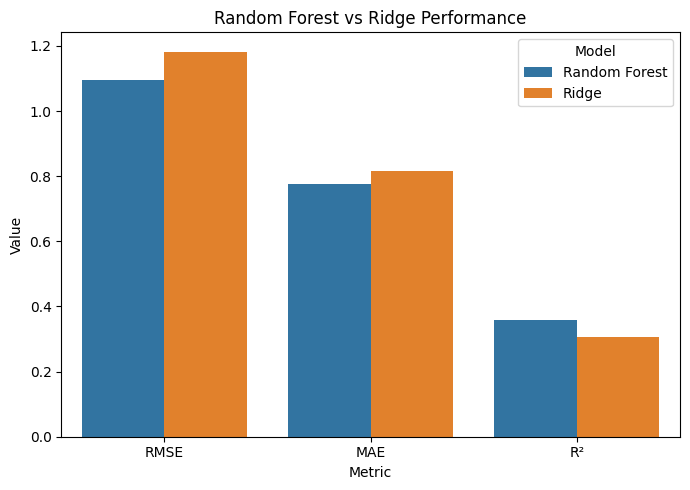

In [ ]:
# Data from Random Forest and Ridge Regression Models
data = {
    "Model": ["Random Forest", "Random Forest", "Random Forest",
              "Ridge", "Ridge", "Ridge"],
    "Metric": ["RMSE", "MAE", "R²", "RMSE", "MAE", "R²"],
    "Value": [rf_rmse, rf_mae, rf_r2, ridge_rmse, ridge_mae, ridge_r2]
}

df_metric = pd.DataFrame(data)

plt.figure(figsize=(7, 5))
sns.barplot(data=df_metric, x="Metric", y="Value", hue="Model")
plt.title("Random Forest vs Ridge Performance")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

#**Preferred Model-Random Forest**
The above performance metric graph shows the one sided nature of a comparison between the two models. Our Random Forest Model predicting moving ratings is superior to the Ridge Regression model in every metric. It boasts lower $RMSE$ and $MAE$ scores, while also having a higher $R^2$, meaning it has smaller errors whilst simultaneuously explaining more of the data.

In [ ]:
def bin_ratings(arr, bin_width = 1.0, high = 10.0):
  bins = np.arange(0.0, high + bin_width, bin_width)
  labels = [f"{i}-{i+bin_width}" for i in range(0, int(high), int(bin_width))]
  idx = np.digitize(arr, bins, right=True) - 1
  idx = np.clip(idx, 0, len(labels) - 1)
  # Create a regular Series first, then convert to CategoricalDtype
  s = pd.Series([labels[i] for i in idx])
  return s.astype(pd.CategoricalDtype(categories=labels, ordered=True))

y_test_bins = bin_ratings(y_test.values)
rf_pred_bins = bin_ratings(rf_pred)

cm = confusion_matrix(y_test_bins, rf_pred_bins, labels=y_test_bins.cat.categories)
cm_df = pd.DataFrame(cm, index=[f"Actual {c}" for c in y_test_bins.cat.categories],
                     columns=[f"Predicted {c}" for c in y_test_bins.cat.categories])
cm_df

,Predicted 0-1.0,Predicted 1-2.0,Predicted 2-3.0,Predicted 3-4.0,Predicted 4-5.0,Predicted 5-6.0,Predicted 6-7.0,Predicted 7-8.0,Predicted 8-9.0,Predicted 9-10.0
Actual 0-1.0,0,0,0,0,3,2,1,0,0,0
Actual 1-2.0,0,0,0,9,9,14,10,2,0,0
Actual 2-3.0,0,0,0,45,98,54,26,7,0,0
Actual 3-4.0,0,0,0,56,300,207,79,3,0,0
Actual 4-5.0,0,0,0,54,507,676,275,10,0,0
Actual 5-6.0,0,0,0,17,344,1403,1034,55,0,0
Actual 6-7.0,0,0,0,4,101,1096,2364,290,0,0
Actual 7-8.0,0,0,0,0,19,242,1180,467,0,0
Actual 8-9.0,0,0,0,0,10,93,214,115,0,0
Actual 9-10.0,0,0,0,0,3,18,30,1,0,0


#**ERROR DISTANCE PLOT**

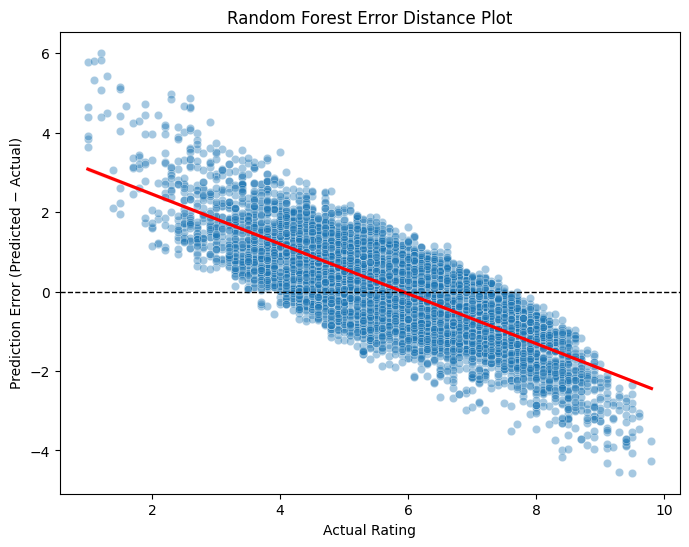

In [ ]:
# Compute error distance
errors = rf_pred - y_test

# Build dataframe
err_df = pd.DataFrame({
    "Actual": y_test,
    "Error": errors
})

plt.figure(figsize=(8,6))

# Scatter with jitter for readability
sns.scatterplot(
    data=err_df,
    x="Actual",
    y="Error",
    alpha=0.4
)

# Line of best fit for error as a function of actual
sns.regplot(
    data=err_df,
    x="Actual",
    y="Error",
    scatter=False,
    color="red"
)

# Horizontal zero-error line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Random Forest Error Distance Plot")
plt.xlabel("Actual Rating")
plt.ylabel("Prediction Error (Predicted − Actual)")
plt.show()


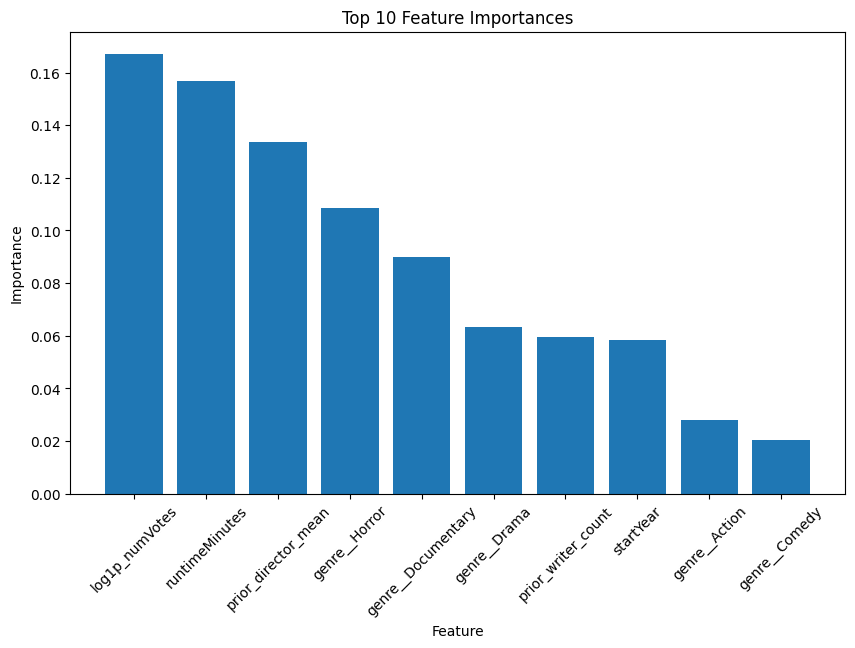

In [ ]:
from sklearn.metrics.pairwise import paired_cosine_distances
# Extract feature importance from fitted model

best_rf_model = rf_cv.best_estimator_.named_steps["model"]
feature_importances = num_features + list(X_train.columns[len(num_features):])

importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_importances[i] for i in indices[:top_n]], rotation=45)
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()




#**INITIAL RESULT ANALYSIS**

The initial results are promising, but we need to correct some insitutional errors in our model in order to increase validity and statistical precision. Comparing the two models, we can see that the Random Forest Model is superior to the Ridge Regression in predicting cinema ratings all across the board. The random forest model yields lower $RMSE$ and $MAE$ scores  while also yielding a higher $R^2$, meaning it has smaller errors whilst simultaneuously explaining more of the data.

However, while the Random Forest is our superior model, it is far from perfect. We can see via the confusion matrix and the error distance plot that our model has a hard time predicting extremes, particularly movies with poor ratings (1-3) and extremely good ratings (8-10).

Finding the root of this is a little tricky, but there are a few methods. We can increase tree depth and sample leaves to help reinforce a more nuanced fit of the model. Additionally, we could add more explanatory variables to add another predicition metric.

# Plots & Summary Tables

#Histogram of Average Ratings

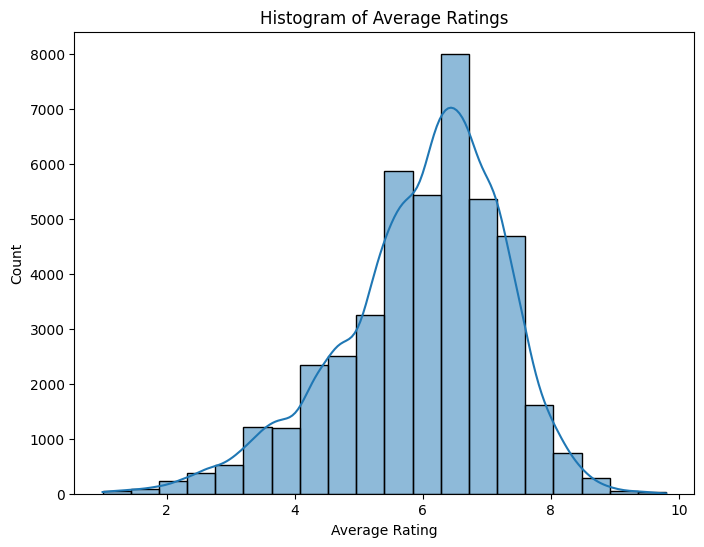

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['averageRating'], bins = 20, kde = True)
plt.xlabel('Average Rating')
plt.title('Histogram of Average Ratings')
plt.show()

#Bar Chart of Genre Frequency

/tmp/ipython-input-1207385528.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genres), y=list(counts), palette="tab20")


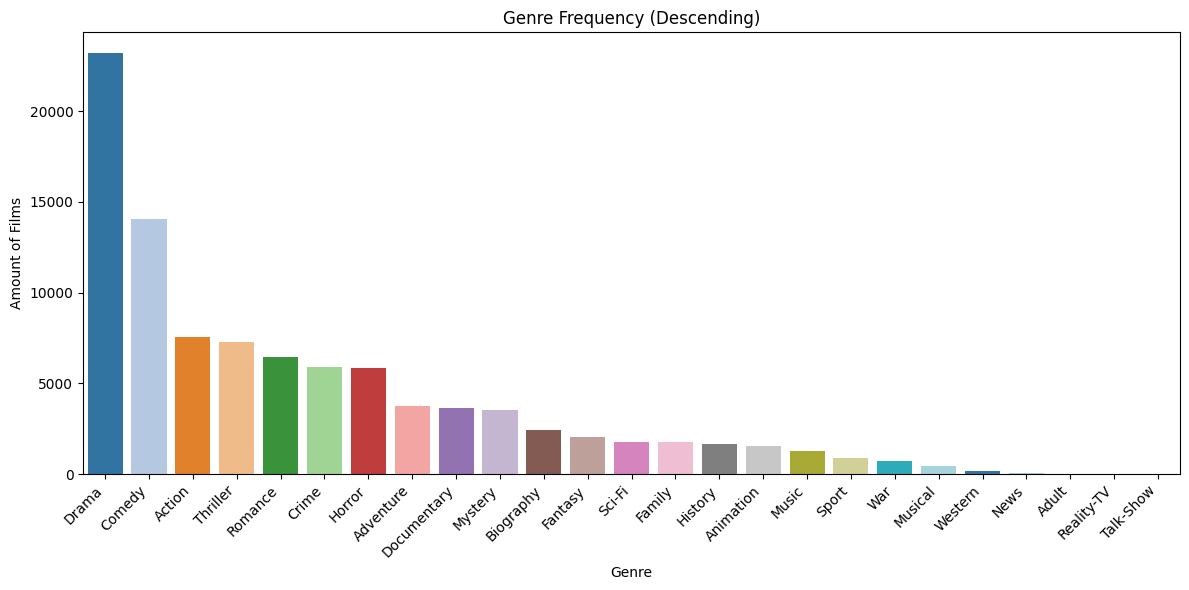

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count each genre in all lists
genre_counts = Counter([g for sublist in df['genres_parsed'] for g in sublist])

# Sort genres by frequency (descending)
genres, counts = zip(*sorted(genre_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genres), y=list(counts), palette="tab20")

plt.xticks(rotation=45, ha='right')
plt.title("Genre Frequency (Descending)")
plt.xlabel("Genre")
plt.ylabel("Amount of Films")
plt.tight_layout()
plt.show()


#Histogram of Movie Length

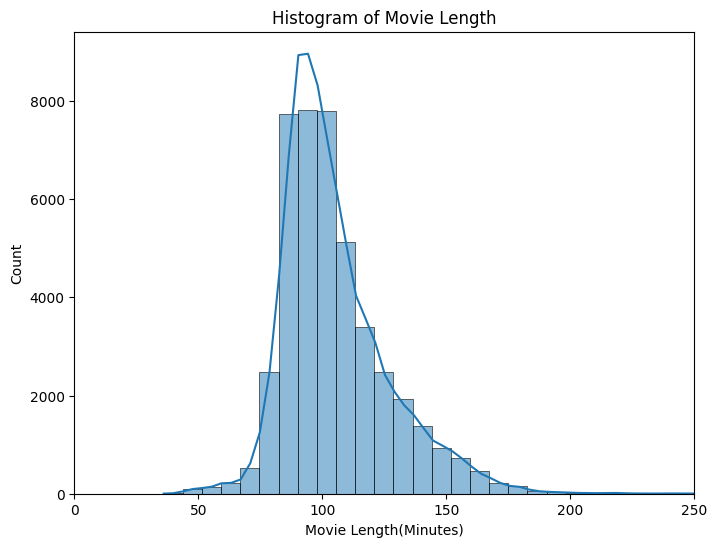

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['runtimeMinutes'], bins = 100, kde = True)
plt.xlim(0, 250)
plt.xlabel('Movie Length(Minutes)')
plt.title('Histogram of Movie Length')
plt.show()


#Summary Table of runtime, averagerating, and number of votes

In [ ]:
# Select numeric columns you want summaries for
numeric_cols = ['runtimeMinutes', 'averageRating', 'numVotes']

summary = df[numeric_cols].describe().T  # Transpose for readability

# Add variance manually (describe does not include it)
summary['variance'] = df[numeric_cols].var()

summary


,count,mean,std,min,25%,50%,75%,max,variance
runtimeMinutes,43816.0,105.207573,22.929030,36.0,90.0,100.0,115.0,808.0,5.257404e+02
averageRating,43816.0,5.982173,1.274876,1.0,5.3,6.2,6.9,9.8,1.625310e+00
numVotes,43816.0,19641.979345,83247.557412,500.0,877.0,1852.0,6080.5,3077253.0,6.930156e+09


#Histogram of Logged NumVotes

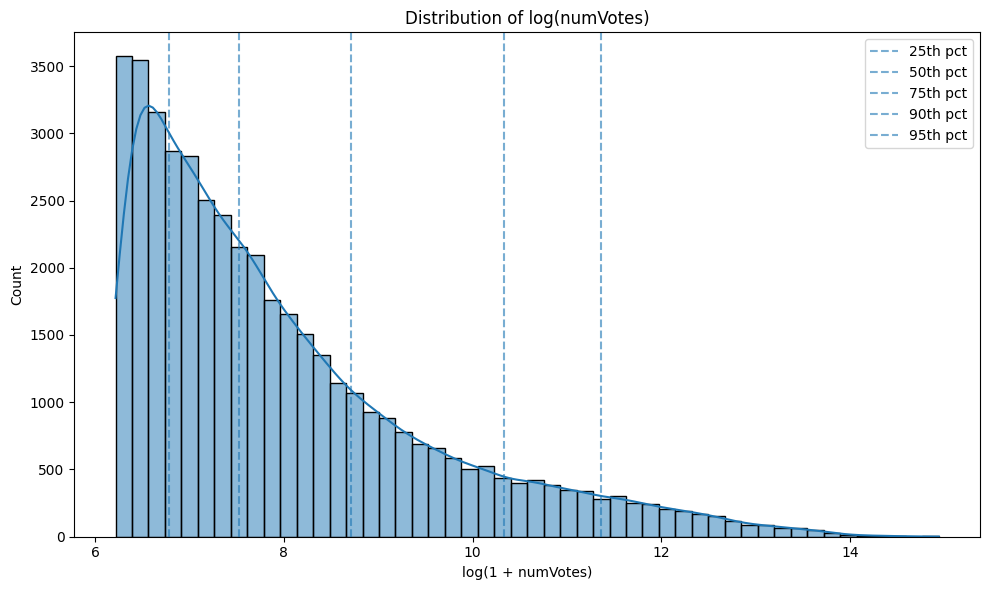

In [ ]:
log_votes = np.log1p(df['numVotes'])

plt.figure(figsize=(10, 6))
sns.histplot(log_votes, bins=50, kde=True)

# Percentiles
for p in [25, 50, 75, 90, 95]:
    plt.axvline(np.percentile(log_votes, p), linestyle="--", alpha=0.6, label=f"{p}th pct")

plt.title("Distribution of log(numVotes)")
plt.xlabel("log(1 + numVotes)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

#Predicted vs Actual Scatterplot for Movie Ratings (Post-Analysis)

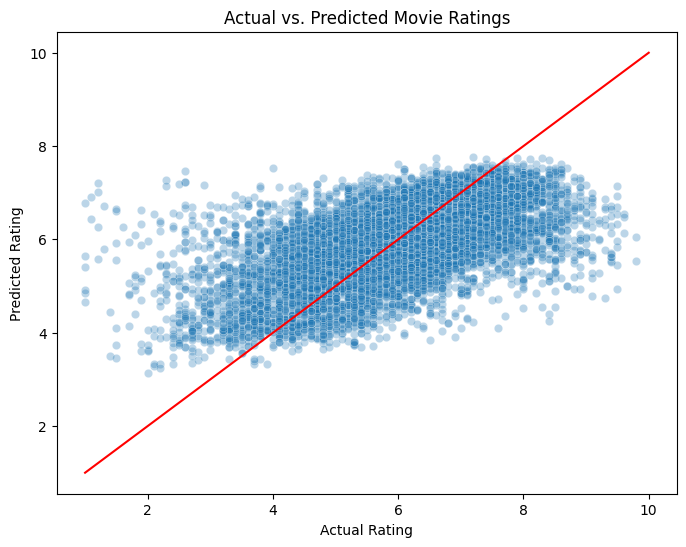

In [ ]:
# Predicted vs Actual Scatterplot

plt.figure(figsize=(8, 6))
sns.scatterplot(x = y_test, y = rf_pred, alpha = 0.3)
plt.plot([1,10], [1,10], color = 'red')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Movie Ratings')
plt.show()



#Histogram of Prediction Errors

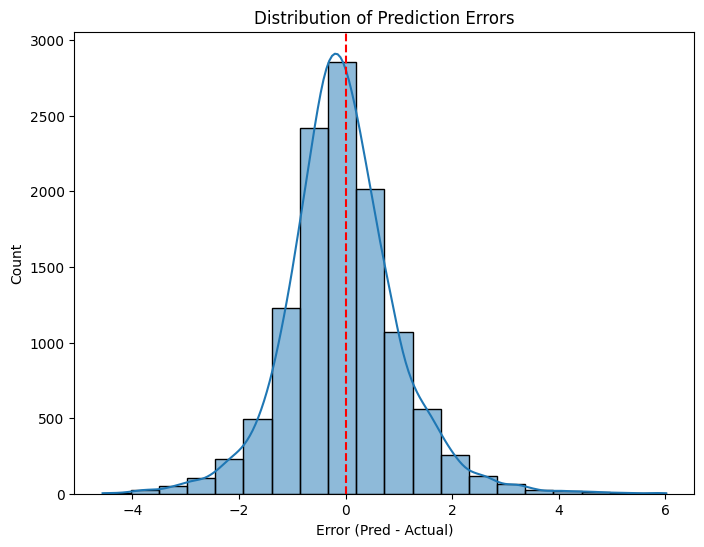

In [ ]:
# Residual distribution

errors = rf_pred - y_test

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=20, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Error (Pred - Actual)')
plt.title('Distribution of Prediction Errors')
plt.show()

#Confusion Matrix Heaman (Bins)

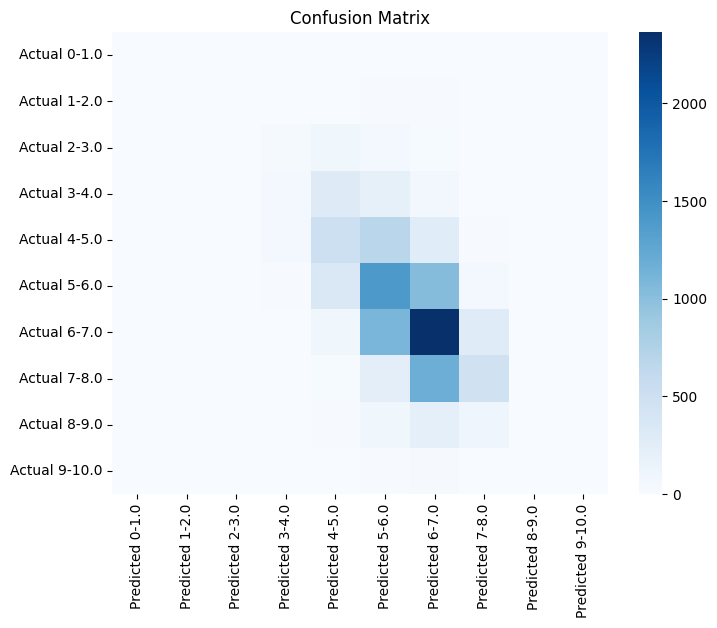

In [ ]:
# Confusion Matrix Heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=False, cmap = "Blues", fmt = "d")
plt.title('Confusion Matrix')
plt.show()